### Processes raw data to continuous neural data + sleep/wake labels
Currently supports:
- a0f - day 6,7,8
- cb4 - day 7,8,9


In [1]:
# imports
import numpy as np
import h5py 
import math 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# options
save_on = 1
plot_on = 0
day = 6
subj_id = 'a0f66459'
# subj_id = 'cb46fd46'
path = "/Users/sunh20/School/Research/sleep_class"

In [3]:
# load raw data

filename = path + "/DATA/" + subj_id + "/ecog/processed_" + subj_id + "_" + str(day) + ".h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))
ecog_d = fin.get('dataset')
fs = int(fin.get('f_sample')[()])
chan_label = fin.get('chanLabels')


['Kurt_channels', 'SD_channels', 'allChanArtifactInds', 'chanLabels', 'dataset', 'f_sample', 'goodChanInds', 'standardizeDenoms', 'start_timestamp', 'start_timestamp_nw']


In [4]:
# get grid + channel data
# first index = event data (ignore)
ECOG_data = ecog_d[1:65,].transpose();
print('ECOG_data:',ECOG_data.shape)

chan = np.arange(1,65)

if subj_id == 'a0f66459':
    # remove ch 37 (bad channel) + make list of channels
    chan = np.delete(chan,37-1)

    ECOG_data = np.delete(ECOG_data,37-1,1)

    print('Removed channel 37')
    print('ECOG_data:', ECOG_data.shape)
    print(chan)

ECOG_data: (42764078, 64)
Removed channel 37
ECOG_data: (42764078, 63)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]


In [5]:
# check start time - make sure it lines up with video times
import datetime
print('start time:')
print(datetime.datetime.utcfromtimestamp(fin.get('start_timestamp')[()]))

start time:
2015-09-25 08:13:24


In [6]:
def get_seconds(time):
    '''
    input time as tuple (hour, min, second) as integers
    returns time in seconds from 00:00 (midnight)
    '''
    return time[0]*60*60 + time[1]*60 + time[2]

In [37]:
# get segment of continuous neural data
# define start, end time
# create sleep/wake labels

if subj_id == 'cb46fd46':
    if day == 7:
        print('not yet implemented')

    else:
        print('day not supported for subj %s' % subj_id)
elif subj_id == 'a0f66459':
    if day == 6:
        t_record_start = get_seconds([8,13,25])
        t_start = get_seconds([17,37,35])
        t_end = get_seconds([24,0,0]) + get_seconds([5,1,34])
        
        sleep_wake_transitions = [
            t_start,
            get_seconds([21,21,36]),
            get_seconds([21,33,36]),
            get_seconds([21,37,35]),
            get_seconds([23,1,36]),
            get_seconds([23,7,37]),
            get_seconds([24,0,0]) + get_seconds([0,23,35]),
            get_seconds([24,0,0]) + get_seconds([0,57,35]),
            get_seconds([24,0,0]) + get_seconds([4,1,35]),
            get_seconds([24,0,0]) + get_seconds([4,5,35]),
            t_end
        ]
        sleep = False # is pt sleeping at t_start

    elif day == 7:
        print('not yet implemented')
    elif day == 8:
        print('not yet implemented')

    else:
        print('day not supported for subj %s' % subj_id)
else:
    print('subj %s not supported' % subj_id)

# adjust to get start indices for wake + sleep
t_data_start = (int)((t_start - t_record_start)*fs)
t_data_end = (int)((t_end - t_record_start)*fs)

data_neuro = ECOG_data[t_data_start:t_data_end]
t = np.linspace(t_data_start,t_data_end,len(data_neuro))

# create data labels - alternate between sleep + wake
data_labels = np.zeros([len(data_neuro),])

for i in range(len(sleep_wake_transitions)-1):
    start_idx = (sleep_wake_transitions[i] - t_start)*fs
    end_idx = (sleep_wake_transitions[i+1] - t_start)*fs
    if ~sleep:
        data_labels[start_idx:end_idx] = 1
    sleep = ~sleep
    
print('t:',t.shape)
print('data_neuro:', data_neuro.shape)
print('data_labels:', data_labels.shape)


t: (20519500,)
data_neuro: (20519500, 63)
data_labels: (20519500,)


Text(0.5, 0, 'time (s)')

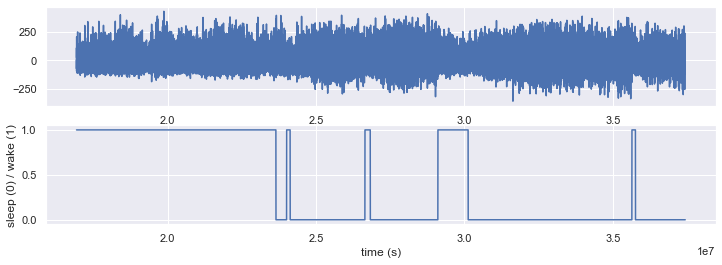

In [38]:
# plot data with labels

plt.figure(figsize=[12,4])
plt.subplot(2,1,1)
plt.plot(t,data_neuro[:,0])
plt.subplot(2,1,2)
plt.plot(t,data_labels)
plt.ylabel('sleep (0) / wake (1)')
plt.xlabel('time (s)')

In [39]:
if save_on:
    outname = "" + subj_id + "_d" + str(day) + "_continuous_labeled.h5"
    with h5py.File(outname,'w') as f:
        f.create_dataset('data_neuro', data=data_neuro)
        f.create_dataset('data_labels',data=data_labels)
        f.create_dataset('t', data=t)
        f.create_dataset('chan',data=chan)
    print('saving completed')

saving completed
